In [168]:
from google.colab import files

# Upload file from local system
uploaded = files.upload()

!unzip -q hw1.zip
%cd hw1

Saving hw1.zip to hw1.zip
/content/hw1/hw1/hw1/hw1/hw1/hw1


# Problem 1: Python & Data Exploration

In [169]:
# Write and run your code here

import numpy as np
import matplotlib.pyplot as plt

# this is used to load the text file
iris = np.genfromtxt("data/iris.txt",delimiter=None)
# the last column is the label
Y = iris[:,-1]
# all other columns are features
X = iris[:,0:-1]

In [170]:
# 1.1

X.shape

# 148 is the size of the dataset
# 4 is the number of features that each data point consists of

(148, 4)

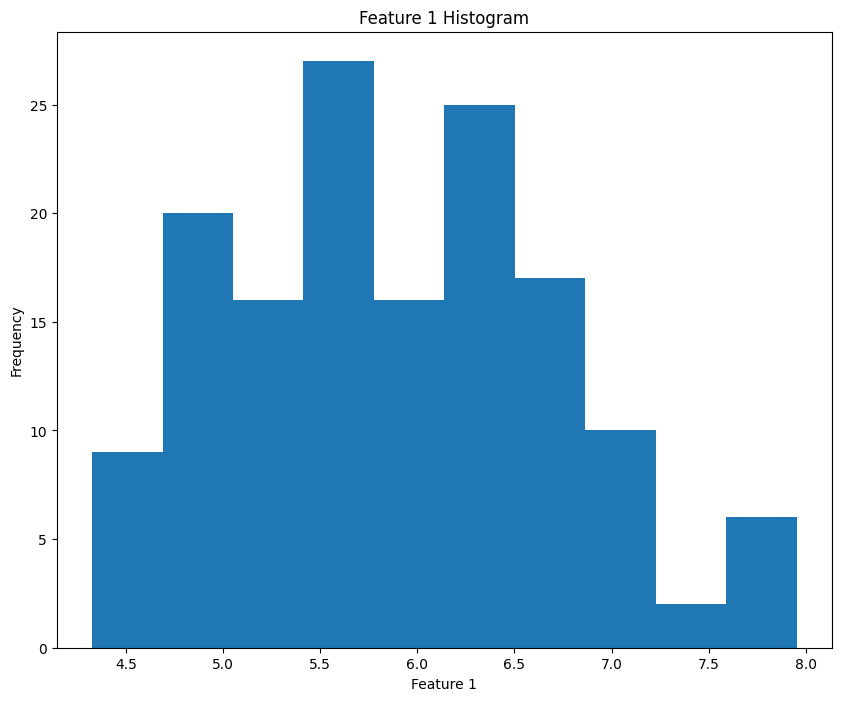

In [171]:
# 1.2

plt.hist(X[:,0])
plt.title('Feature 1 Histogram')
plt.xlabel('Feature 1')
plt.ylabel('Frequency')
plt.show()

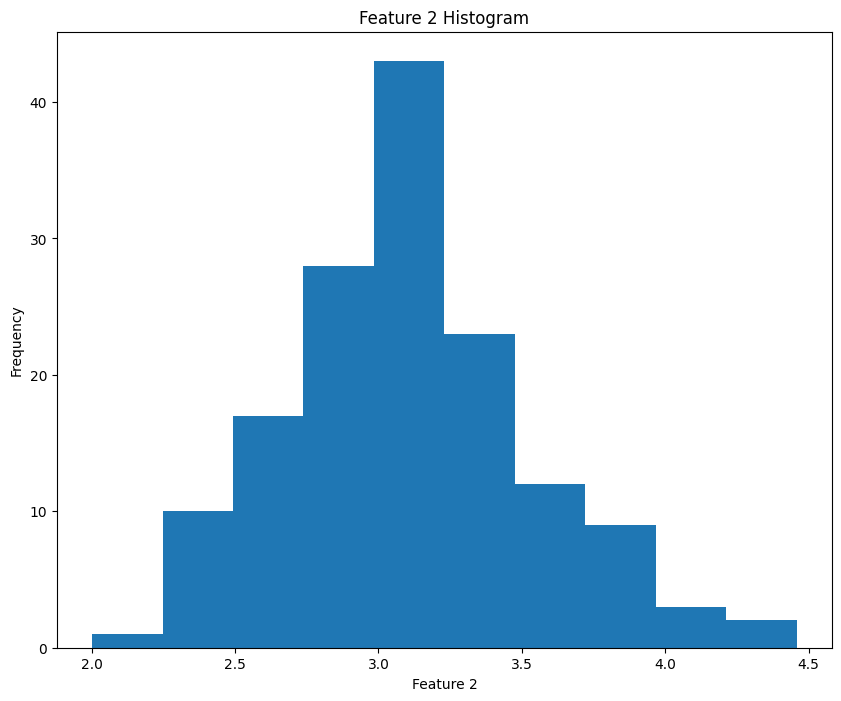

In [172]:
# 1.2

plt.hist(X[:,1])
plt.title('Feature 2 Histogram')
plt.xlabel('Feature 2')
plt.ylabel('Frequency')
plt.show()

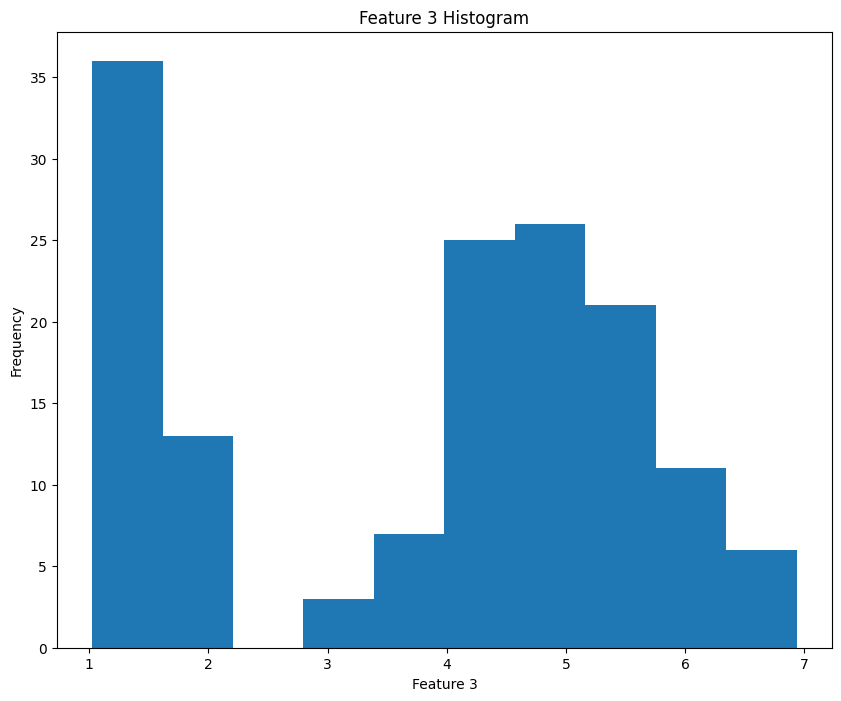

In [173]:
# 1.2

plt.hist(X[:,2])
plt.title('Feature 3 Histogram')
plt.xlabel('Feature 3')
plt.ylabel('Frequency')
plt.show()

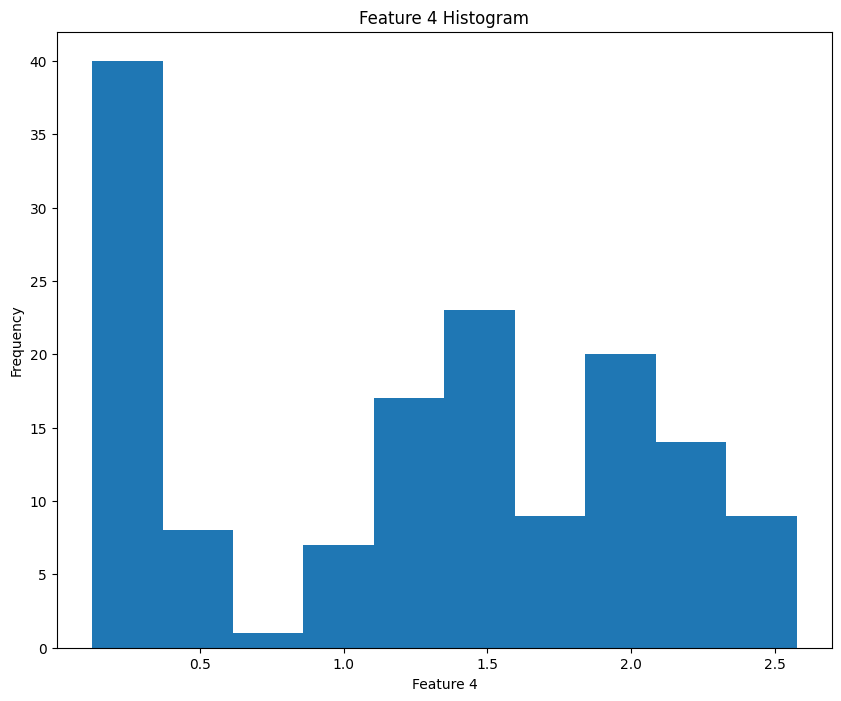

In [174]:
# 1.2

plt.hist(X[:,3])
plt.title('Feature 4 Histogram')
plt.xlabel('Feature 4')
plt.ylabel('Frequency')
plt.show()

In [175]:
# 1.3

for i in range(4):
  print("Feature #{}: Mean = {}, Standard Deviation = {}".format(i + 1, np.mean(X[:, i]), np.std(X[:, i])))

Feature #1: Mean = 5.900103764189188, Standard Deviation = 0.833402066774894
Feature #2: Mean = 3.098930916891892, Standard Deviation = 0.43629183800107685
Feature #3: Mean = 3.8195548405405404, Standard Deviation = 1.7540571093439352
Feature #4: Mean = 1.2525554845945945, Standard Deviation = 0.7587724570263247


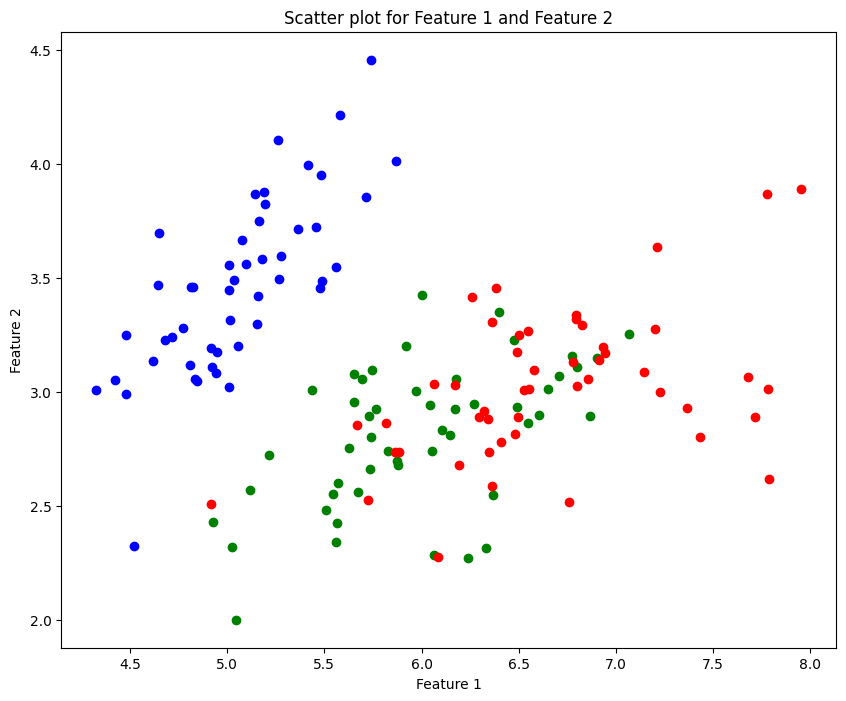

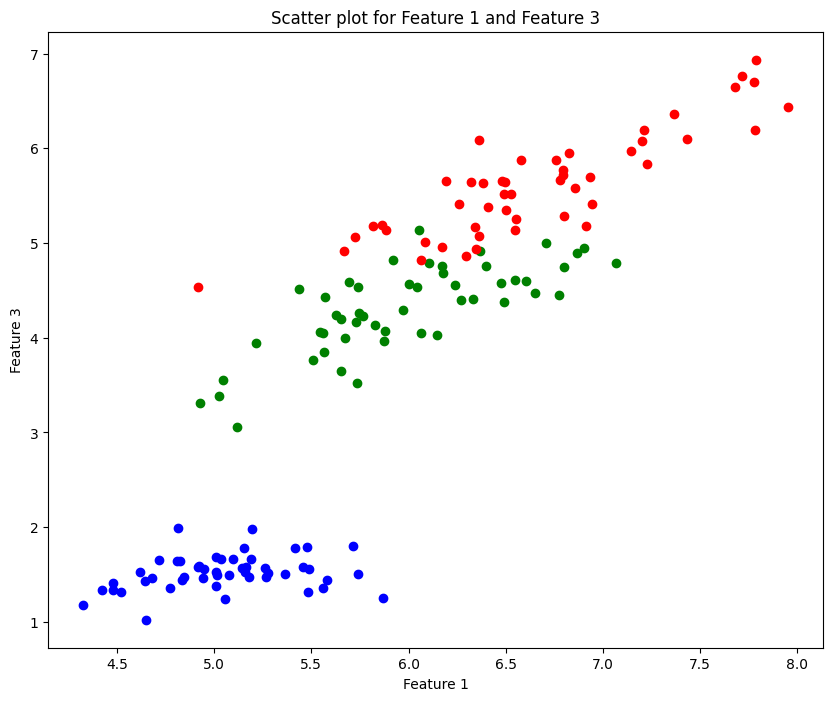

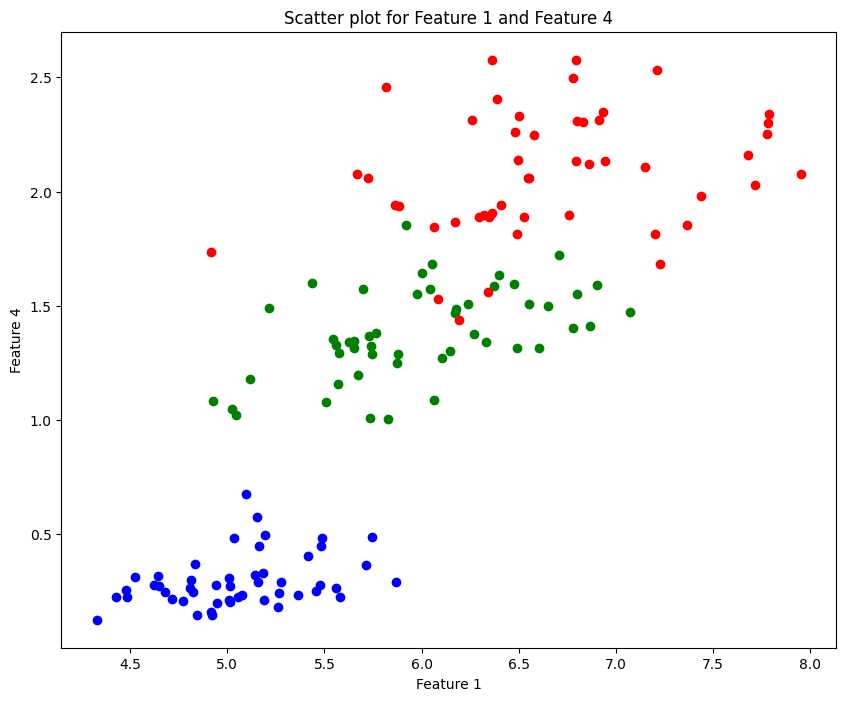

In [176]:
# 1.4

# Get unique target values (classes) from label array Y
target_value = np.unique(Y)
# Iterate over feature indices
for feature in range(1,4):
    # Iterate over each unique target value (class)
    for category in target_value:
        # Assign colors based on target value
        if int(category) == 0:
            color = "blue"
        elif int(category) == 1:
            color = "green"
        else:
            color = "red"
        # Plot scatter plot of Feature 1 vs current feature (points only belonging
        # to current target value (category) are plotted)
        plt.scatter(X[Y == category, 0], X[Y == category, feature], color = color)
    # Specifications for the scatter plot
    plt.xlabel("Feature 1")
    plt.ylabel(f"Feature {feature + 1}")
    plt.title(f"Scatter plot for Feature 1 and Feature {feature + 1}")
    plt.show()


# Problem 2: k-Nearest Neighbor (kNN) exercise


The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [177]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs273p.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

In [178]:
%cd cs273p/datasets
!source get_datasets.sh

/content/hw1/hw1/hw1/hw1/hw1/hw1/cs273p/datasets
--2025-01-18 03:04:51--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  56.1MB/s    in 2.9s    

2025-01-18 03:04:55 (56.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [179]:
%cd ../..

/content/hw1/hw1/hw1/hw1/hw1/hw1


In [180]:
# Load the raw CIFAR-10 data.
cifar10_dir = './cs273p/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


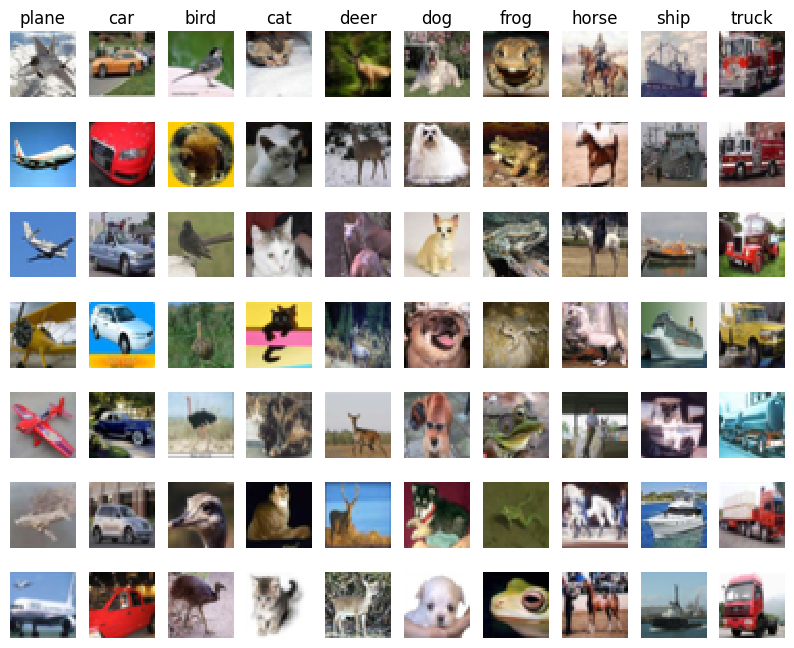

In [181]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [182]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [183]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [184]:
from cs273p.classifiers import KNearestNeighbor

# Create a kNN classifier instance.
# Remember that training a kNN classifier is a noop:
# the Classifier simply remembers the data and does no further processing
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs273p/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [185]:
# Open cs273p/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


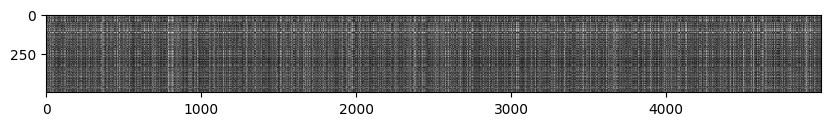

In [186]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: *fill this in.*



In [187]:
'''
Bright rows indicate that the images in the training set are far from the testing image.
Bright columns indicate that the images in the testing set are far from the training image.
'''

'\nBright rows indicate that the images in the training set are far from the testing image.\nBright columns indicate that the images in the testing set are far from the training image.\n'

In [188]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [189]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

In [190]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [191]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [192]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 34.754031 seconds
One loop version took 50.669889 seconds
No loop version took 0.702784 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [193]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
#pass

X_train_folds = np.split(X_train, 5)
y_train_folds = np.split(y_train, 5)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
#pass

# Iterate through each k value in k_choices
for k in k_choices:
  # Perform cross-validation for each fold
  for j in range(num_folds):
    # Combine all the folds (except the jth fold) into the training set
    X_train = np.concatenate((*X_train_folds[:j], *X_train_folds[j+1:]), axis = 0)
    y_train = np.concatenate((*y_train_folds[:j], *y_train_folds[j+1:]), axis = 0)

    # Use the jth fold as the validation set
    X_val = X_train_folds[j]
    y_val = y_train_folds[j]

    # Train kNN classifier using training data
    classifier.train(X_train, y_train)
    # Calculate distances between validation and training sets
    dists = classifier.compute_distances_no_loops(X_val)
    # Predict labels for validation set using current value of k
    y_val_pred = classifier.predict_labels(dists, k=k)
    # Calculate number of correct predictions
    num_correct_preds = np.sum(y_val_pred == y_val)

    # Initialize list for k in dictionary if it doesn't exist
    if k not in k_to_accuracies:
      k_to_accuracies[k] = []
    # Append accuracy for current fold to list for current value of k
    k_to_accuracies[k].append(float(num_correct_preds) / y_val.shape[0])

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

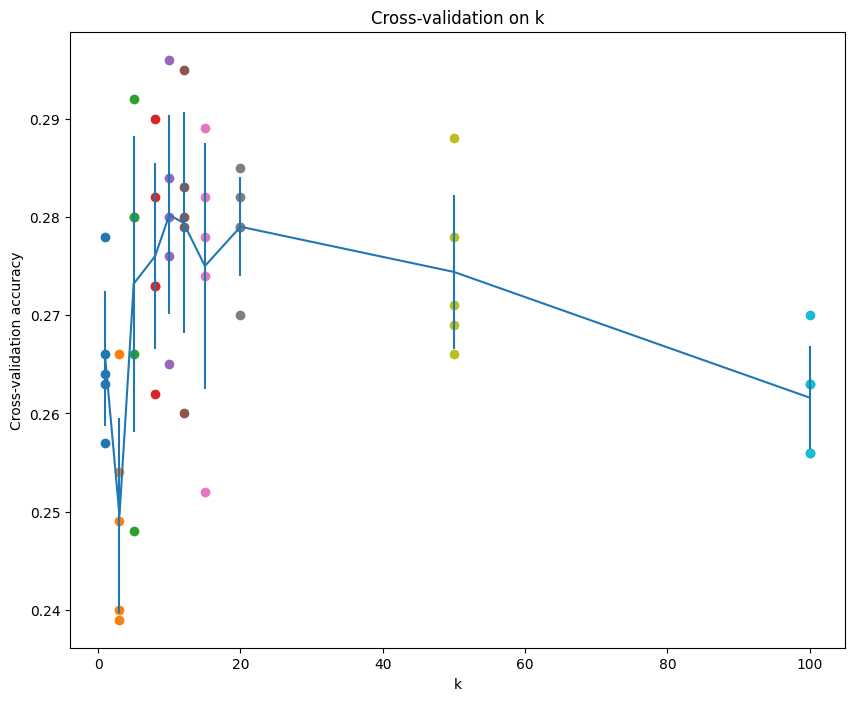

In [194]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [195]:
# Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 12

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 142 / 500 correct => accuracy: 0.284000


# Problem 3: Naïve Bayes Classifiers


You don't need to code this question. You can either type your answer or attach an image of hand written solution here.

In [196]:
# '''

# 3.1: Compute all the probabilities necessary for a naïve Bayes classifier, i.e., the class
# probability p(y) and all the individual feature probabilities p(xi|y),
# for each class y and feature xi

# p(y = 1) = 4/10 = 2/5
# p(y = −1) = 6/10 = 3/5

# p(x1 = 0 | y = 1) = 1/4
# p(x1 = 1 | y = 1) = 3/4
# p(x1 = 0 | y = −1) = 3/6 = 1/2
# p(x1 = 1 | y = −1) = 3/6 = 1/2

# p(x2 = 0 | y = 1) = 1
# p(x2 = 1 | y = 1) = 0
# p(x2 = 0 | y = −1) = 1/6
# p(x2 = 1 | y = −1) = 5/6

# p(x3 = 0 | y = 1) = 1/4
# p(x3 = 1 | y = 1) = 3/4
# p(x3 = 0 | y = −1) = 2/6 = 1/3
# p(x3 = 1 | y = −1) = 4/6 = 2/3

# p(x4 = 0 | y = 1) = 2/4 = 1/2
# p(x4 = 1 | y = 1) = 2/4 = 1/2
# p(x4 = 0 | y = −1) = 1/6
# p(x4 = 1 | y = −1) = 5/6

# p(x5 = 0 | y = 1) = 3/4
# p(x5 = 1 | y = 1) = 1/4
# p(x5 = 0 | y = −1) = 4/6 = 2/3
# p(x5 = 1 | y = −1) = 2/6 = 1/3

# ------------------------------------------------------------------------------------------------------------------------------------------------------

# 3.2 Which class would be predicted for x = (00000)? What about for x = (11010)?

# p(y = 1 | x = 00000) = p(y = 1, x = 00000) / p(x = 00000)
# = p(y = 1, x = 00000) / (p(y = -1, x = 00000) + p(y = 1, x = 00000))
# = (p(x = 00000 | y = 1) * p(y = 1)) / ((p(x = 00000 | y = -1) * p(y = -1)) + ((p(x = 00000 | y = 1) * p(y = 1)))) = 0.84
# p(y = −1 | x = 00000) = 0.17

# p(y = 1 | x = 11010) = 0
# p(y = −1 | x = 11010) = 1

# Therefore, for x = (00000), the predicted class would be read since the predicted y for (00000) would be 1,
# and for x = (11010), the predicted class would be discard since the predicted y for (11010) would be -1.

# ------------------------------------------------------------------------------------------------------------------------------------------------------

# 3.3 Compute the posterior probability that y = +1 given the observation x = (11010).

# p(y = 1 | x = 11010) = (p(x = 11010 | y = 1) * p(y = 1)) / ((p(x = 11010 | y = -1) * p(y = -1)) + ((p(x = 11010 | y = 1) * p(y = 1))))

# p(x = 11010 | y = 1) * p(y = 1)
# = p(x1 = 1 | y = 1) * p(x2 = 1 | y = 1) * p(x3 = 0 | y = 1) * p(x4 = 1 | y = 1) * p(x5 = 0 | y = 1) * p(y = 1)
# = 3/4 * 0 * 3/4 * 1/2 * 1/4 = 0

# Therefore, the posterior probability that y = +1 given the observation x = (11010) is 0.

# ------------------------------------------------------------------------------------------------------------------------------------------------------

# 3.4 Why should we probably not use a “joint” Bayes classifier (using the joint probability of the features x, as opposed to a
# naïve Bayes classifier) for these data?

# A small or sparse dataset may result in many zeros in the table which can lead to overfitting when using joint probability.
# The Naive Bayes classifier proves to be better as it assumes conditional independence and the number of parameters to estimate
# is reduced since the joint probability is broken into smaller parts. Therefore, we probably shouldn't use a “joint” Bayes classifier
# for these data since in this case, the table is far too big to handle with joint probability.

# ------------------------------------------------------------------------------------------------------------------------------------------------------

# 3.5 Suppose that, before we make our predictions, we lose access to my address book, so that we cannot tell whether the email author
# is known. Should we re-train the model, and if so, how? (e.g.: how does the model, and its parameters, change in this new situation?)
# Hint: what will the naïve Bayes model over only features x2 . . . x5 look like, and what will its parameters be?

# The following equation can be used even in the absence of a feature to calculate the posterior probability:

# p(y | x2...x5)

# = p(y, x2...x5) / p(x2...x5)

# = (∑   p(y, x1...x5)) / (∑     p(y, x1...x5)) = (∑   (p(x1 | y)...p(x5 | y) * p(y))) / (∑     (p(x1 | y)...p(x5 | y) * p(y)))
#     x1                    x1,y                    x1                                     x1,y

# Therefore, the model can be retrained this way using 4 input features instead of 5.

# '''

In [197]:
# '''
# Statement of Collaboration

# In discussion on Friday I discussed Naive Bayes Classifier with Ingrid and Nicole and Ingrid recommended resources for
# further studying and understanding of the topic.

# I worked alone and used all resources available from Canvas to complete this assignment.
# '''